<h1>Capstone 1: Final Report</h1>

<p>This is my final report on my capstone project for Springboard. I will be breaking this report into the following sections:
<br>1. Framing the problem (What is the problem/why is it important?)
<br>2. Data Wrangling/Data Collection - What assumptions will we be needing to make in this data?
<br>3. Exploratory Data - What can we say about the data/strong correlations
<br>4. Applying a Linear Regression Model
<br>5. Apply a Random Forest Model
<br>6. Conclusion/Next steps</p>

<p>Let us first import the necessary libraries for this project.</p>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nba_py.player import PlayerSummary
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn'

<h2> 1. Framing the problem (What is the problem/why is it important?)</h2>
<p>Over the past few years, fantasy sports, especially fantasy football and basketball is becoming more popular. As such, the need for reliable estimators of fantasy sports statistical categories is becoming more and more important. We know that the more accurate the estimator is for the week, the more the user/team owner can use this data to choose who they can play for the week depending on their projected statistical categories. Currently many users use the year-to-date averages for their sports statistics as an estimator. Our goal is to use a machine learning algorithm to project out our statistical categories.</p>
<p>While we would love to be able to do this for every single stat, we unfortunately do not have the time currently. We may do this later on. For now, we will be focusing on the points statistical category.</p>

<h2>2. Data Wrangling/Data Collection - What assumptions will we be needing to make in this data?</h2>
<p>Fortunately for us, we have a nice API to work with the NBA stats website per the link: https://github.com/seemethere/nba_py . We will be using three different dataframes from this API:
<br>1. GameLog by Player
<br>2. GameLog by Teams
<br>3. PlayerStats for that specific year</p>
<p>We will take one year of these libraries and show what we are going to be doing in terms of combining these three dataframes into one.</p>

In [1]:
from nba_py.league import PlayerStats, GameLog
sample_season = "2017-18"

In [ ]:
#GameLog by Player
GameLog(season=sample_season,player_or_team='P').overall().head()

In [ ]:
#GameLog by Team
GameLog(season=sample_season,player_or_team='T').overall().head()

In [ ]:
PlayerStats(season=sample_season, StarterBench="Starters",PlayerPosition="C").overall().head()

<p>What we will be doing here is combining the team statistics for the gamelogs with the player's game logs. We will be doing this so we can create some of the fantasy statistics from this base level information (e.g. PACE of the teams, Offensive Efficiency, Defensive Efficiency).</p>
<p>We will be using the PlayerStats to filter out players that we are not interested in. We only care about players who play a significant amount of minutes and a significant amount of games. After all, a player who players 5 games and averages 2 minutes per game may skew our data. Thus we will be removing players who play less than 30 games and averages less than 15 minutes per game. We've already done this step in our data wrangling stage.</p>
<p>It is also important to note that there are filters that we can apply in PlayerStats to get the player's playing position (center, forward or guard) and the number of games they started vs the number of games they were a bench player. We will be combining these to see which players are bonafide starters, who are sometimes a starter/sometimes not, and who is a bench player.</p>
<p>Please note that we've cleaned our data and completed several of the steps in the data wrangling, exploratory data analysis, and machine learning portion of this capstone project. The result of which is the below dataset.</p>

In [2]:
training_observation = pd.read_csv('../Final_Dataset/training_observation.csv')
training_observation.head()

Unnamed: 0  PTS HOME_AWAY  GAME_NUMBER    C    G ALL_STAR STARTER  \
0           3    2      HOME            3  1.0  0.0       NO     YES   
1           4    4      HOME            4  1.0  0.0       NO     YES   
2           5    8      HOME            5  1.0  0.0       NO     YES   
3           6   12      AWAY            6  1.0  0.0       NO     YES   
4           7    4      AWAY            7  1.0  0.0       NO     YES   

   MIN_LASTGAME  FG2M_LASTGAME    ...     FTM_AVGLAST3GAMES  \
0          20.0            3.0    ...              1.333333   
1          25.0            1.0    ...              1.333333   
2          13.0            2.0    ...              0.000000   
3          28.0            3.0    ...              0.666667   
4          27.0            5.0    ...              1.333333   

   FTA_AVGLAST3GAMES   PTS_YTD    MIN_YTD  FG2M_YTD  FG2A_YTD  FG3M_YTD  \
0           1.333333  9.000000  25.750000  4.000000  9.500000       0.0   
1           1.333333  8.000000  23.200000  3.600000  8.200000       0.0   
2           0.000000  8.000000  24.000000  3.500000  8.333333       0.0   
3           0.666667  8.571429  24.428571  3.714286  8.285714       0.0   
4           1.333333  8.000000  23.000000  3.500000  7.875000       0.0   

   FG3A_YTD   FTM_YTD   FTA_YTD  
0       0.0  1.000000  1.000000  
1       0.0  0.800000  0.800000  
2       0.0  1.000000  1.000000  
3       0.0  1.142857  1.142857  
4       0.0  1.000000  1.000000  

[5 rows x 35 columns]

In [3]:
training_observation['F'] = 0
for index, row in training_observation.iterrows():
    F_value = 0
    if row['C'] + row['G'] == 0:
        F_value = 1
    training_observation.set_value(index, 'F', F_value)

C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


<h2>3. Exploratory Data - What can we say about the data/strong correlations</h2>
<p>Now, per the below graph, we can see that there is an increasing trend as the number of games are played. Thus, we will need to include dummy variables for all games. We should not be judging a player in game 1 the same as a player in game 81 as they are more likely to score higher points.</p>

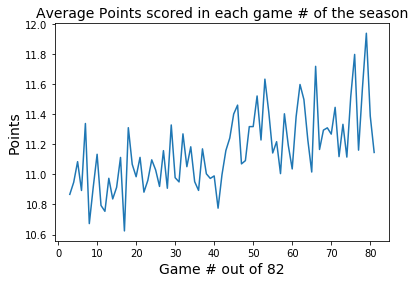

In [4]:
_ = plt.plot(training_observation[['GAME_NUMBER', 'PTS']].groupby(['GAME_NUMBER']).mean())
_ = plt.xlabel('Game # out of 82', fontsize=14)
_ = plt.ylabel('Points', fontsize=14)
_ = plt.title('Average Points scored in each game # of the season', fontsize=14)

<p>Also note that we are including the player position as we found in our exploratory data analysis phase, the player position matters. This is because guards are more likely to score more points (most likely because of three pointers) vs centers or forwards. As such, we are including a category for these. Note that this will be a dummy variable later on.</p>
<p>We're also including a category for all-stars and setting it to players who average above 32 minutes or more per game. We're including all-star players average nearly double the points that non-allstar players score.</p>

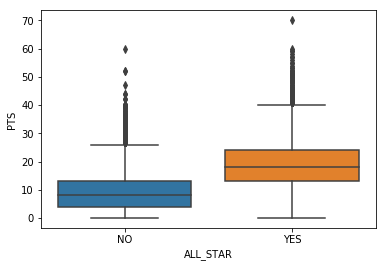

In [5]:
allstar_bp = sns.boxplot(x="ALL_STAR", y="PTS", data=training_observation)
plt.show()

<p>We did a correlation heatmap and found the statistical features to be included in this for individual players. </p>
<p>As well, note that we are including the average  YTD PACE for the player's team and their opponent. As well, we are including the team's YTD average offensive rating as well as the opponent team's average defensive rating. We are including the PACE because we would need be trying to get a best estimate what that PACE of the game would bel like. The higher the PACE, the more points they are likely to score. As well, we are including the offensive ratings because a team with a higher offensive rating is more likely to score more.</p>

<h2>4. Applying a Linear Regression Model </h2>
<p>We had previously applied a linear regression model in our data and found that our dataset was missing a few important features (i.e. PACE of the game, all-star vs non-all-star). Our hypothesis was that all-stars were skewing our data as our predicted scores were always inflated. Thus now that we have a flag for all-stars, we should split our linear regression into two - one linear regression for all-stars and another for non-all-stars and come up with the mean absolute error.</p>

In [7]:
#Reading in our datasets
training_observation = pd.read_csv('../Final_Dataset/training_observation.csv')
test_observation = pd.read_csv('../Final_Dataset/test_observation.csv')

In [8]:
#Splitting our datasets into allstars vs normal
training_allstars = training_observation[training_observation['ALL_STAR'] == 'YES'].drop(columns=['Unnamed: 0','ALL_STAR'])
training_normal = training_observation[training_observation['ALL_STAR'] == 'NO'].drop(columns=['Unnamed: 0','ALL_STAR'])
test_allstars = test_observation[test_observation['ALL_STAR'] == 'YES'].drop(columns=['Unnamed: 0','ALL_STAR'])
test_normal = test_observation[test_observation['ALL_STAR'] == 'NO'].drop(columns=['Unnamed: 0','ALL_STAR'])

In [9]:
#Getting Dummy Variables
d_training_allstars = pd.get_dummies(training_allstars,columns=['STARTER','HOME_AWAY','GAME_NUMBER'], drop_first=True)
d_training_normal = pd.get_dummies(training_normal, columns=['STARTER','HOME_AWAY','GAME_NUMBER'], drop_first=True)
d_test_allstars = pd.get_dummies(test_allstars, columns=['STARTER','HOME_AWAY','GAME_NUMBER'], drop_first=True)
d_test_normal =  pd.get_dummies(test_normal,columns=['STARTER','HOME_AWAY','GAME_NUMBER'], drop_first=True)

In [10]:
#Reindexing
m_training_allstars = d_training_allstars.reindex(columns = d_training_allstars.columns, fill_value=0)
m_training_normal = d_training_normal.reindex(columns = d_training_normal.columns, fill_value=0)
m_test_allstars = d_test_allstars.reindex(columns = d_test_allstars.columns, fill_value=0)
m_test_normal =  d_test_normal.reindex(columns = d_test_normal.columns, fill_value=0)

In [11]:
m_training_normal = m_training_normal.drop(columns='STARTER_NO')
m_test_normal = m_test_normal.drop(columns='STARTER_NO')

In [12]:
#Splitting our data into X and y
X_training_allstars = m_training_allstars.drop(columns=['PTS', 'PTS_AVGLAST3GAMES','PTS_YTD'])
y_training_allstars = m_training_allstars['PTS']
X_training_normal = m_training_normal.drop(columns=['PTS', 'PTS_AVGLAST3GAMES','PTS_YTD'])
y_training_normal = m_training_normal['PTS']
X_test_allstars = m_test_allstars.drop(columns=['PTS', 'PTS_AVGLAST3GAMES','PTS_YTD'])
y_test_allstars = m_test_allstars['PTS']
X_test_normal =  m_test_normal.drop(columns=['PTS', 'PTS_AVGLAST3GAMES','PTS_YTD'])
y_test_normal = m_test_normal['PTS']

In [13]:
#Initializing our Regressors
allstar_regressor = LinearRegression()
normal_regressor = LinearRegression()

#Fitting our training data to the regressor
allstar_regressor.fit(X_training_allstars, y_training_allstars)
normal_regressor.fit(X_training_normal, y_training_normal)

#Checking the scores
allstar_score = allstar_regressor.score(X_test_allstars, y_test_allstars)
normal_score = normal_regressor.score(X_test_normal, y_test_normal)
print("The R squared for all-stars is: " + str(allstar_score))
print("The R squared for normal players is: " + str(normal_score))

The R squared for all-stars is: 0.32781341405382136
The R squared for normal players is: 0.34230883855172023


In [14]:
allstar_data = test_allstars
normal_data = test_normal

In [15]:
all_star_ytd_error = abs(allstar_data['PTS_YTD'] - allstar_data['PTS'])
all_star_mean_ytd_error = np.mean(all_star_ytd_error)
all_star_regressor_pred = allstar_regressor.predict(X_test_allstars)

all_star_regressor_error = abs(all_star_regressor_pred - allstar_data['PTS'].values)
all_star_mean_regressor_error = np.mean(all_star_regressor_error)
print("Our Y-T-D mean absolute error is: "+ str(all_star_mean_ytd_error) + ". Our Regressor Error is: "+ str(all_star_mean_regressor_error))

Our Y-T-D mean absolute error is: 5.567889468907355. Our Regressor Error is: 5.5960774194927145


In [16]:
ytd_error = abs(normal_data['PTS_YTD'] - normal_data['PTS'])
mean_ytd_error = np.mean(ytd_error)
regressor_pred = normal_regressor.predict(X_test_normal)
#for x in allstar_regressor.predict(X_test_allstars):
#    for i in x:
#        regressor_pred.append(i)
regressor_error = abs(regressor_pred - normal_data['PTS'].values)
mean_regressor_error = np.mean(regressor_error)
print("Our Y-T-D mean absolute error is: "+ str(mean_ytd_error) + ". Our Regressor Error is: "+ str(mean_regressor_error))

Our Y-T-D mean absolute error is: 4.21638579338224. Our Regressor Error is: 4.187551000825548


From here, we see that our regression algorithm performed better than the Y-T-D average for normal players. It did not perform that well on our all-stars (however it is generally pretty close!). I believe this may be because there are generally more outliers in our all-star data. All-stars are more capable of "going off" and have a 40+ point game - which is not normal for most players. Thus we see our Y-T-D mean absolute error to be higher in both our Y-T-D mean and the regressor.

In [17]:
#Creating a new regression specific data frame with Y-T-D results & the regression results
allstar_data['REGRESSOR_ERROR'] = all_star_regressor_error
allstar_data['REGRESSION_PRED'] = all_star_regressor_pred
allstar_data['YTD_ERROR'] = all_star_ytd_error

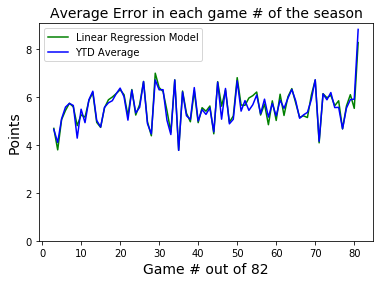

In [18]:
allstar_reg_ytd_errors = plt.plot(allstar_data[['GAME_NUMBER', 'REGRESSOR_ERROR']].groupby(['GAME_NUMBER']).mean(), color="green", label="Linear Regression Model")
allstar_reg_ytd_errors = plt.plot(allstar_data[['GAME_NUMBER', 'YTD_ERROR']].groupby(['GAME_NUMBER']).mean(), color="blue", label="YTD Average")
allstar_reg_ytd_errors = plt.legend()
allstar_reg_ytd_errors = plt.xlabel('Game # out of 82', fontsize=14)
allstar_reg_ytd_errors = plt.ylabel('Points', fontsize=14)
allstar_reg_ytd_errors = plt.title('Average Error in each game # of the season', fontsize=14)
allstar_reg_ytd_errors = plt.ylim(ymin=0)

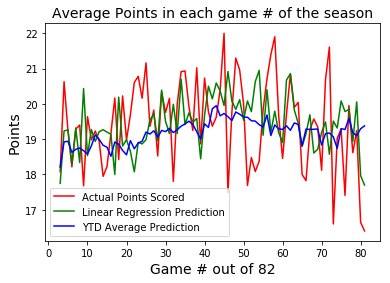

In [19]:
allstar_reg_ytd_pts = plt.plot(allstar_data[['GAME_NUMBER', 'PTS']].groupby(['GAME_NUMBER']).mean(), color="red", label="Actual Points Scored")
allstar_reg_ytd_pts = plt.plot(allstar_data[['GAME_NUMBER', 'REGRESSION_PRED']].groupby(['GAME_NUMBER']).mean(), color="green", label="Linear Regression Prediction")
allstar_reg_ytd_pts = plt.plot(allstar_data[['GAME_NUMBER', 'PTS_YTD']].groupby(['GAME_NUMBER']).mean(), color="blue", label="YTD Average Prediction")
allstar_reg_ytd_pts = plt.legend()
allstar_reg_ytd_pts = plt.xlabel('Game # out of 82', fontsize=14)
allstar_reg_ytd_pts = plt.ylabel('Points', fontsize=14)
allstar_reg_ytd_pts = plt.title('Average Points in each game # of the season', fontsize=14)

Thus we see in these graphs, that our model (the line in green) does mimic average points quite well. However, the only issue is that it mimics it a little bit too late. There looks to be a bit of a delay in some of the points. For example, we see this at the 45 game mark. We may need to apply a shifting here to measure this. However, I believe we have a good starting point for our machine learning algorithm.

In [21]:
import statsmodels.api as sm
model = sm.OLS(y_training_normal, X_training_normal)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     1599.
Date:                Wed, 12 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:16:54   Log-Likelihood:            -1.4715e+05
No. Observations:               47766   AIC:                         2.945e+05
Df Residuals:                   47659   BIC:                         2.954e+05
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C                     -0.2198      0

<p>We can see from here that there is a high likelihood of multicollinearity due to the large condition number. I believe tht this is due to the fact that we have are using our last 3 games and last games played. Let's drop these and check the summary statistics w.r.t. normal players only. Below is a function to remove the multi-collinearity columns. This analyzes the variance inflation factor (VIF) and removes any columns that is higher than 5.</p>

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [23]:
X_training_normal_2 = calculate_vif_(X_training_normal)

dropping 'OPP_PACE' at index: 11
dropping 'PACE' at index: 9
dropping 'OPP_DEF_RATING' at index: 10
dropping 'FG2A_YTD' at index: 19
dropping 'MIN_AVGLAST3GAMES' at index: 10
dropping 'OFF_RATING' at index: 9
dropping 'FTA_YTD' at index: 20
dropping 'FG3A_YTD' at index: 18
dropping 'MIN_YTD' at index: 15
dropping 'FG2A_AVGLAST3GAMES' at index: 10
dropping 'FTA_AVGLAST3GAMES' at index: 13
dropping 'FG3A_AVGLAST3GAMES' at index: 11
dropping 'FG2M_YTD' at index: 12
dropping 'MIN_LASTGAME' at index: 2
dropping 'FTM_LASTGAME' at index: 6
dropping 'FG2A_LASTGAME' at index: 3
dropping 'FG2M_AVGLAST3GAMES' at index: 6
dropping 'FG3M_YTD' at index: 8
dropping 'FTM_YTD' at index: 8
dropping 'FG3A_LASTGAME' at index: 4
Remaining variables:
Index(['C', 'G', 'FG2M_LASTGAME', 'FG3M_LASTGAME', 'FTA_LASTGAME',
       'FG3M_AVGLAST3GAMES', 'FTM_AVGLAST3GAMES', 'STARTER_YES',
       'HOME_AWAY_HOME', 'GAME_NUMBER_4', 'GAME_NUMBER_5', 'GAME_NUMBER_6',
       'GAME_NUMBER_7', 'GAME_NUMBER_8', 'GAME_NUMBER

In [24]:
model_2 = sm.OLS(y_training_normal, X_training_normal_2)
results_2 = model_2.fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     1547.
Date:                Wed, 12 Sep 2018   Prob (F-statistic):               0.00
Time:                        13:37:56   Log-Likelihood:            -1.5152e+05
No. Observations:               47766   AIC:                         3.032e+05
Df Residuals:                   47679   BIC:                         3.040e+05
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C                      0.1466      0

<p>With this step, we have systematically removed all the features which have multicollinearity. Let's remove these from our test set as well to ensure that our model will predict accurately.</p>

In [25]:
X_test_normal_2 = X_test_normal[['C', 'G', 'FG2M_LASTGAME', 'FG3M_LASTGAME', 'FTA_LASTGAME',
       'FG3M_AVGLAST3GAMES', 'FTM_AVGLAST3GAMES', 'STARTER_YES',
       'HOME_AWAY_HOME', 'GAME_NUMBER_4', 'GAME_NUMBER_5', 'GAME_NUMBER_6',
       'GAME_NUMBER_7', 'GAME_NUMBER_8', 'GAME_NUMBER_9', 'GAME_NUMBER_10',
       'GAME_NUMBER_11', 'GAME_NUMBER_12', 'GAME_NUMBER_13', 'GAME_NUMBER_14',
       'GAME_NUMBER_15', 'GAME_NUMBER_16', 'GAME_NUMBER_17', 'GAME_NUMBER_18',
       'GAME_NUMBER_19', 'GAME_NUMBER_20', 'GAME_NUMBER_21', 'GAME_NUMBER_22',
       'GAME_NUMBER_23', 'GAME_NUMBER_24', 'GAME_NUMBER_25', 'GAME_NUMBER_26',
       'GAME_NUMBER_27', 'GAME_NUMBER_28', 'GAME_NUMBER_29', 'GAME_NUMBER_30',
       'GAME_NUMBER_31', 'GAME_NUMBER_32', 'GAME_NUMBER_33', 'GAME_NUMBER_34',
       'GAME_NUMBER_35', 'GAME_NUMBER_36', 'GAME_NUMBER_37', 'GAME_NUMBER_38',
       'GAME_NUMBER_39', 'GAME_NUMBER_40', 'GAME_NUMBER_41', 'GAME_NUMBER_42',
       'GAME_NUMBER_43', 'GAME_NUMBER_44', 'GAME_NUMBER_45', 'GAME_NUMBER_46',
       'GAME_NUMBER_47', 'GAME_NUMBER_48', 'GAME_NUMBER_49', 'GAME_NUMBER_50',
       'GAME_NUMBER_51', 'GAME_NUMBER_52', 'GAME_NUMBER_53', 'GAME_NUMBER_54',
       'GAME_NUMBER_55', 'GAME_NUMBER_56', 'GAME_NUMBER_57', 'GAME_NUMBER_58',
       'GAME_NUMBER_59', 'GAME_NUMBER_60', 'GAME_NUMBER_61', 'GAME_NUMBER_62',
       'GAME_NUMBER_63', 'GAME_NUMBER_64', 'GAME_NUMBER_65', 'GAME_NUMBER_66',
       'GAME_NUMBER_67', 'GAME_NUMBER_68', 'GAME_NUMBER_69', 'GAME_NUMBER_70',
       'GAME_NUMBER_71', 'GAME_NUMBER_72', 'GAME_NUMBER_73', 'GAME_NUMBER_74',
       'GAME_NUMBER_75', 'GAME_NUMBER_76', 'GAME_NUMBER_77', 'GAME_NUMBER_78',
       'GAME_NUMBER_79', 'GAME_NUMBER_80', 'GAME_NUMBER_81']]

In [27]:
#Initializing our Regressors
normal_regressor_2 = LinearRegression()

#Fitting our training data to the regressor
normal_regressor_2.fit(X_training_normal_2, y_training_normal)

#Checking the scores
normal_score_2 = normal_regressor_2.score(X_test_normal_2, y_test_normal)
print("The R squared for normal players is: " + str(normal_score_2))

The R squared for normal players is: 0.2101979039797992


In [29]:
regressor_pred_2 = normal_regressor_2.predict(X_test_normal_2)
#for x in allstar_regressor.predict(X_test_allstars):
#    for i in x:
#        regressor_pred.append(i)
regressor_error_2 = abs(regressor_pbred_2 - normal_data['PTS'].values)
mean_regressor_error_2 = np.mean(regressor_error_2)
print("Our Y-T-D mean absolute error is: "+ str(mean_ytd_error) + ". Our Regressor Error is: "+ str(mean_regressor_error_2))

Our Y-T-D mean absolute error is: 4.21638579338224. Our Regressor Error is: 4.604177002432667


<p>As we can see, our model did not perform well when we removed the multicollinear variables in our dataset. While this may be true, our model does not break any of the regression rules. Thus we can use the results and the coefficients to analyze what variables are important and can explain to our stakeholders.</p>

<h2>5. Apply a Random Forest Model </h2>

<p>Let's see if we can do better with a random forest model. A key issue with a random forest model however, is the issue of overfitting. As such, we need to be careful about how we choose our hyperparameters and ensure that we cross-validate in to ensure that we are not overfitting.</p>

In [107]:
training_set = training_observation.drop(columns=['Unnamed: 0','ALL_STAR'])
test_set = test_observation.drop(columns=['Unnamed: 0','ALL_STAR'])

In [108]:
training_set['F'] = 0
for index, row in training_set.iterrows():
    F_value = 0
    if row['C'] + row['G'] == 0:
        F_value = 1
    training_set.set_value(index, 'F', F_value)

C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [109]:
test_set['F'] = 0
for index, row in test_set.iterrows():
    F_value = 0
    if row['C'] + row['G'] == 0:
        F_value = 1
    test_set.set_value(index, 'F', F_value)

C:\Users\Boris-Tsao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [110]:
training_position = training_set[['C','G','F']].idxmax(axis=1)
test_position = test_set[['C','G','F']].idxmax(axis=1)

In [111]:
training_set['POSITION'] = training_position
test_set['POSITION'] = test_position

training_set = training_set.drop(columns=['C','G','F'])
test_set = test_set.drop(columns=['C','G','F'])

In [113]:
X_train = training_set.drop(columns=['PTS'])
y_train = training_set['PTS']
X_test = test_set.drop(columns=['PTS'])
y_test = test_set['PTS']

In [114]:
X_train['POSITION'] = X_train['POSITION'].replace({'C':0,'G':1, 'F':2})
X_train['HOME_AWAY'] = X_train['HOME_AWAY'].replace({'HOME':0,'AWAY':1})
X_train['STARTER'] = X_train['STARTER'].replace({'YES':0,'NO':1, 'IN_BETWEEN': 2})
X_test['POSITION'] = X_test['POSITION'].replace({'C':0,'G':1, 'F':2})
X_test['HOME_AWAY'] = X_test['HOME_AWAY'].replace({'HOME':0,'AWAY':1})
X_test['STARTER'] = X_test['STARTER'].replace({'YES':0,'NO':1, 'IN_BETWEEN': 2})

In [115]:
#import RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state = 42)

In [38]:
# Number of trees in random forest
n_estimators = [250,500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 25, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [250, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 25, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [40]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  9.8min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 21.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [250, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 25, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [93]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 25,
 'bootstrap': True}

In [118]:
test = RandomForestRegressor(n_estimators= 500,
 min_samples_split= 5,
 min_samples_leaf= 2,
 max_features= 'auto',
 max_depth= 25,
 bootstrap= True,random_state=42)

In [119]:
test.fit(X_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:
params = {'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 25,
 'bootstrap': True}

<p>Now that we have our best parameters based on our randomized gridsearch, we can apply a gridsearch method around these parameters with a more narrow interval in it. For example, we can try n_estimators to be between 450 to 550 with increments of 50 each.</p>
<p>We can do the same for each, however, due to time contraints, we will not be performing this action just right. Let's analyze our prediction errors vs the ytd total.</p>

In [121]:
predictions = rf_random.predict(X_test)
errors = abs(predictions - y_test.values)
mean_error = np.mean(errors)

In [122]:
errors_ytd_total = abs(training_observation['PTS']-training_observation['PTS_YTD'])
mean_error_ytd_total = np.mean(errors_ytd_total)

In [123]:
print('Our Random Forest error is: ', mean_error, 'Our total YTD error is:', mean_error_ytd_total)

Our Random Forest error is:  4.493545009693851 Our total YTD error is: 4.40930620082221


<p>Unfortunately, we were not lucky in our randomized gridsearch! Our random forest was not able to predict better than our YTD average. We will have to do more parameter tuning later on to ensure that we have the optimal predictor.</p>

<p>For now, we will analyze our model and see where we can improve based on these parameters.</p>

In [127]:
analysis = X_test
analysis['RF_PRED'] = predictions
analysis['PTS'] = y_test

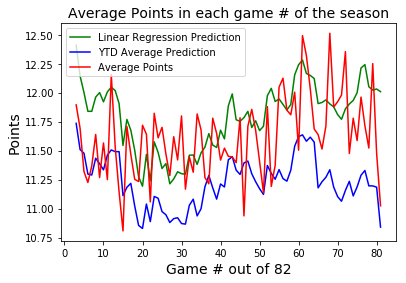

In [129]:
#rf_ytd_pts = plt.plot(analysis[['GAME_NUMBER', 'PTS']].groupby(['GAME_NUMBER']).mean(), color="red", label="Actual Points Scored")
rf_ytd_pts = plt.plot(analysis[['GAME_NUMBER', 'RF_PRED']].groupby(['GAME_NUMBER']).mean(), color="green", label="Linear Regression Prediction")
rf_ytd_pts = plt.plot(analysis[['GAME_NUMBER', 'PTS_YTD']].groupby(['GAME_NUMBER']).mean(), color="blue", label="YTD Average Prediction")
rf_ytd_pts = plt.plot(analysis[['GAME_NUMBER', 'PTS']].groupby(['GAME_NUMBER']).mean(), color="red", label="Average Points")
rf_ytd_pts = plt.legend()
rf_ytd_pts = plt.xlabel('Game # out of 82', fontsize=14)
rf_ytd_pts = plt.ylabel('Points', fontsize=14)
rf_ytd_pts = plt.title('Average Points in each game # of the season', fontsize=14)

<p>Based on our random forest model, with a very minimal amount of optimization, we can see that we have a fairly good trained model where our mean error is below that of the Y-T-D average of points. Let's cut the data between starters, bench and in between and see if there are any places that we can improve the model. </p>

In [130]:
def line_plot_mean(lis_categories, xlab="FILL THIS OUT", ylab="FILL THIS OUT", title="FILL THIS OUT"):
    for item in lis_categories:
        rf_ytd_pts = plt.plot(item['DATA'].groupby(['GAME_NUMBER']).mean(), color=item['COLOR'], label=item['TITLE'])
    rf_ytd_pts = plt.legend()
    rf_ytd_pts = plt.xlabel(xlab, fontsize=14)
    rf_ytd_pts = plt.ylabel(ylab, fontsize=14)
    rf_ytd_pts = plt.title(title, fontsize=14)

In [139]:
starters = [{'DATA': analysis[analysis['STARTER'] == 0 ][['GAME_NUMBER', 'RF_PRED']], 'COLOR': 'green', 'TITLE': 'Random Forest'},
            {'DATA': analysis[analysis['STARTER'] == 0 ][['GAME_NUMBER', 'PTS_YTD']], 'COLOR': 'blue', 'TITLE': 'YTD PTS'},
            {'DATA': analysis[analysis['STARTER'] == 0 ][['GAME_NUMBER', 'PTS']], 'COLOR': 'red', 'TITLE': 'PTS'}]
bench = [{'DATA': analysis[analysis['STARTER'] == 1 ][['GAME_NUMBER', 'RF_PRED']], 'COLOR': 'green', 'TITLE': 'Random Forest'},
         {'DATA': analysis[analysis['STARTER'] == 1 ][['GAME_NUMBER', 'PTS_YTD']], 'COLOR': 'blue', 'TITLE': 'YTD PTS'},
        {'DATA': analysis[analysis['STARTER'] == 1 ][['GAME_NUMBER', 'PTS']], 'COLOR': 'red', 'TITLE': 'PTS'}]
in_between = [{'DATA': analysis[analysis['STARTER'] == 2 ][['GAME_NUMBER', 'RF_PRED']], 'COLOR': 'green', 'TITLE': 'Random Forest'},
              {'DATA': analysis[analysis['STARTER'] == 2 ][['GAME_NUMBER', 'PTS_YTD']], 'COLOR': 'blue', 'TITLE': 'YTD PTS'},
             {'DATA': analysis[analysis['STARTER'] == 2 ][['GAME_NUMBER', 'PTS']], 'COLOR': 'red', 'TITLE': 'PTS'}]

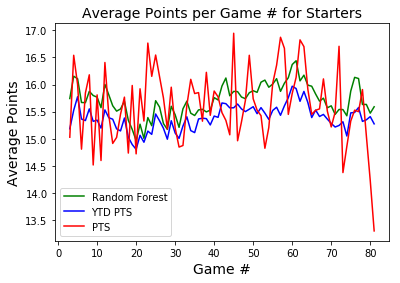

In [140]:
line_plot_mean(starters, xlab="Game #", ylab="Average Points", title="Average Points per Game # for Starters")

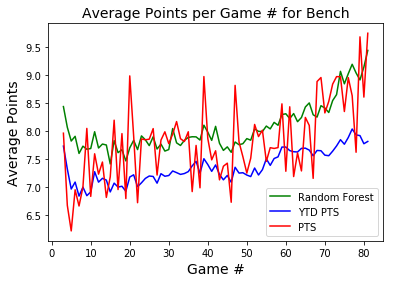

In [141]:
line_plot_mean(bench, xlab="Game #", ylab="Average Points", title="Average Points per Game # for Bench")

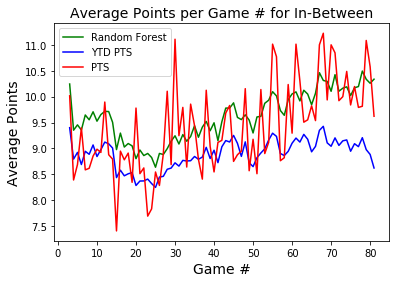

In [142]:
line_plot_mean(in_between, xlab="Game #", ylab="Average Points", title="Average Points per Game # for In-Between")

<p>Based on the above graphs, we see that the the graphs random forest has a much smoother prediction than the average points per player. This may be due to the fact that we are "smoothing" our data by applying the Y-T-D averages and the 3 game average. We may want to remove these to ensure that we capture our data more clearly. </p>

<p>We also note that our starters are much more sporatic. This may be because we are not accounting for who is an all-star player as we see the average points per game to jump down significantly vs that of the random forest predictions. We may need to account for that.</p>

<h2>6. Conclusion/Next steps</h2>

<p>Based on our machine learning algorithms, we have concluded the following:</p>
<p>
1. Using the metric of mean absolute error, our linear regression model was not able to predict out points as accurately as using the Y-T-D average. Especially if we were to remove multicollinearity from our resuls. <br>
2. Random forest regressor was much better at predicting with a mean absolute error of ~4.49 compared to the YTD mean absolute error was ~4.40. We only performed 1 stage of parameter tuning, but believe that as we do more, we should be getting better results.
</p>
<p>Here are methods that I believe can improve our model more (which I will complete later on):</p>
<p>1. Have more granular data. Obviously we had to make some assumptions in our data (e.g. try and pick out who is an all-star and who is not, or who is a starter and who is not). Ideally we do not have to make any assumptions in our data gathering. We would take it for what it is. By us making these assumptions we may be incorparating some biasness in our model that is skewing our results. Thus we would have to do further exploratory data analysis to get this model correct.<br>
2. We would have to due further parameter tuning via gridsearch methods to ensure that we are optimizing our model correctly. Unfortunately, I did not have time to do this for this iteration. But continuously optimizing our parameters is an essential step in ensuring our model is training properly.</p>